# Background
In cells, initiation of cell death can occur through two distinct apoptotic pathways - **intrinsic pathway** or **extrinsic pathway**. Extrinsic pathway is initiated by Fas death receptors (FasR). After Fas ligand (FasL) binding, the FasL/FasR complex would trimerize and form death inducing signaling complex (DISC). DISC would activate **Caspase 8**, then Caspase-8 is able to activate **Caspase 3**. At the same time, Caspase-8 can also regulate intrinsic pathway that happens at mitochondria by activating **BH3 interacting-domain death agonis (BID)**. BID is a pro-apoptotic rgeulator that could activate **Caspase-9**. Active Caspase-9 enhances Caspase-3 activation.

In [2]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import itertools

In [3]:
Image("cell death.jpg")

FileNotFoundError: No such file or directory: 'cell death.jpg'

FileNotFoundError: No such file or directory: 'cell death.jpg'

<IPython.core.display.Image object>

# Modeling of the Caspase Cascade with Positive Feedback

We will model the **extrinsic and intrinsic apoptotic pathways** with major players Caspase-8, Caspase-3, Bid, and Caspase-9:
1. Caspase-8 activation via FasL-FasR signaling
2. Bid cleavage and activation by Caspase-8
3. Caspase-9 activation via Bid
3. Caspase-3 activation by both Caspase-8 and Caspase-9
4. FasL degradation

### **1. Caspase-8 Activation**
Caspase-8 is activated by FasL via a **Hill function**:
$$
\frac{dC_8}{dt} = k_1 \frac{[FasL]^n}{K_d^n + [FasL]^n} - k_2 C_8
$$
- $ C_8 $ = Concentration of active Caspase-8
- $ k_1 $ = Rate of Caspase-8 activation
- $ k_2 $ = Degradation rate of Caspase-8
- $ FasL $ = Death ligand concentration
- $ K_d $ = Dissociation constant
- $ n $ = Hill coefficient
### **2. Bid Cleavage and Activation**
Caspase-8 activates **Bid**, which promotes Caspase-9 activation:
$$
\frac{dB}{dt} = k_3 C_8 - k_4 B
$$
- $ B $ = Concentration of active Bid
- $ k_3 $ = Rate of Bid cleavage by Caspase-8
- $ k_4 $ = Degradation rate of Bid

### **3. Caspase-9 Activation**
Caspase-9 is activated by **Bid**:
$$
\frac{dC_9}{dt} = k_5 B - k_6 C_9
$$
- $ C_9 $ = Concentration of active Caspase-9
- $ k_5 $ = Rate of Caspase-9 activation by Bid
- $ k_6 $ = Degradation rate of Caspase-9

### **4. Caspase-3 Activation**
Caspase-3 is activated by both **Caspase-8 and Caspase-9**:
$$
\frac{dC_3}{dt} = k_7 C_8 + k_8 C_9^m - k_9 C_3
$$
- $ C_3 $ = Concentration of active Caspase-3
- $ k_7 $ = Activation rate of Caspase-3 by Caspase-8 
- $ k_8 $ = Activation rate of Caspase-3 by Caspase-9
- $ k_9 $ = Degradation rate of Caspase-3
- $ m $ = Hill coefficient

### **5. FasL degradation**
FasL level also has great impact on the pathway activation:
$$
\frac{dFasL}{dt} = S_{fasl} - k_{fas} \times FasL
$$
- $ S_{fasl} $ = synthesis rate of FasL
- $ k_{fas} $ = degradation rate of FasL



### **Table: Rate Constants Used in the Our Model**

$$
\begin{array}{|c|c|l|}
\hline
\textbf{Parameter} & \textbf{Description} \\
\hline
k_1 &  \text{Caspase-8 activation rate} \\
k_2 &  \text{Caspase-8 degradation rate} \\
k_3 &  \text{Bid activation rate} \\
k_4 &  \text{Bid degradation rate} \\
k_5 &  \text{Caspase-9 activation rate} \\
k_6 &  \text{Caspase-9 degradation rate} \\
k_7 &  \text{Caspase-3 activation by Caspase-8} \\
k_8 &  \text{Caspase-3 activation by Caspase-9 (positive feedback)} \\
k_9 &  \text{Caspase-3 degradation rate} \\
K_d &  \text{Dissociation constant for Caspase-8 activation} \\
n   &  \text{Hill coefficient for Caspase-8 activation} \\
m   & \text{Hill coefficient for positive feedback from Caspase-9} \\
S_{fasl}  & \text{Synthesis rate of FasL} \\
k_{fas}  & \text{Degradation rate of FasL} \\
\hline
\end{array}
$$



In [4]:
def caspase_cascade_ode(y, t, k1, k2, k3, k4, k5, k6, k7, k8, k9, Kd, n, m, S_fasl, kfas):
    C8, B, C9, C3, FasL = y
    # Caspase-8 activation (with a Hill function) and degradation.
    dC8_dt = k1 * (FasL**n) / (Kd**n + FasL**n) - k2 * C8
    # Bid cleavage and activation.
    dB_dt = k3 * C8 - k4 * B
    # Caspase-9 activation.
    dC9_dt = k5 * B - k6 * C9
    # Caspase-3 activation.
    dC3_dt = k7 * C8 + k8 * (C9**m) - k9 * C3
    # FasL dynamics: synthesis minus degradation.
    dFasL_dt = S_fasl - kfas * FasL
    return [dC8_dt, dB_dt, dC9_dt, dC3_dt, dFasL_dt]



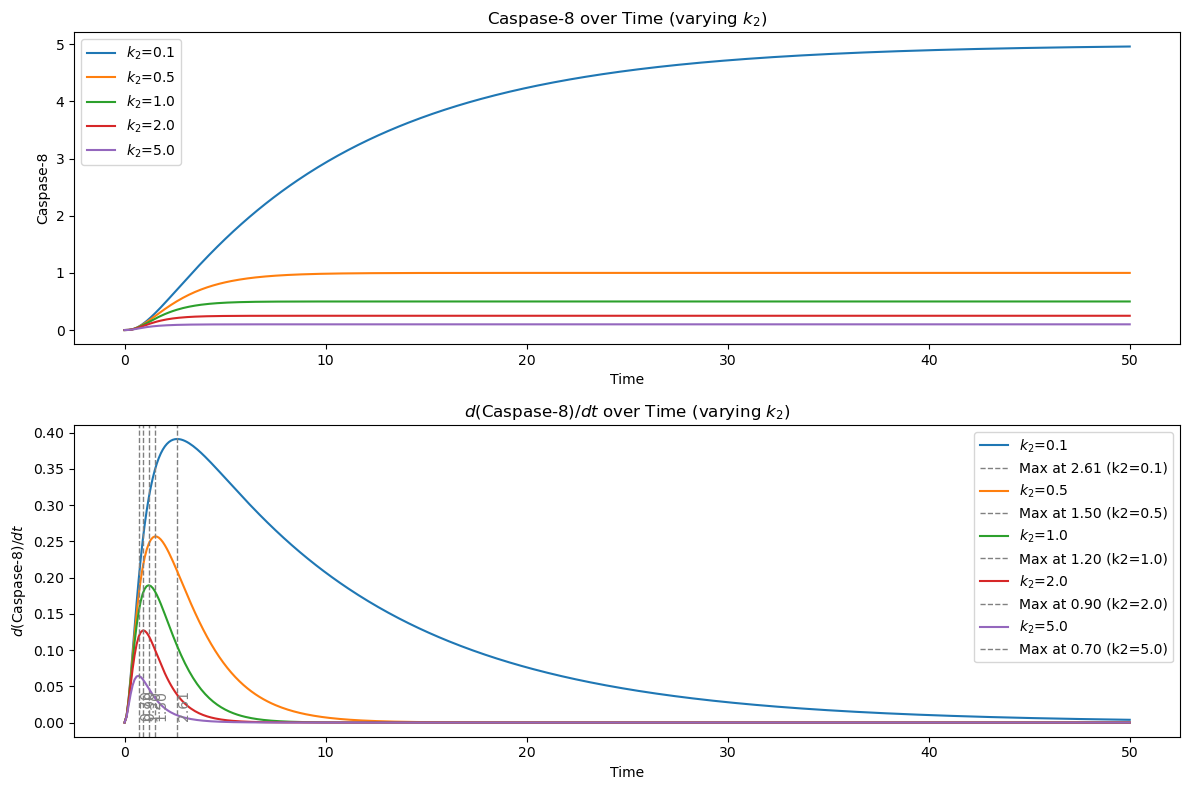

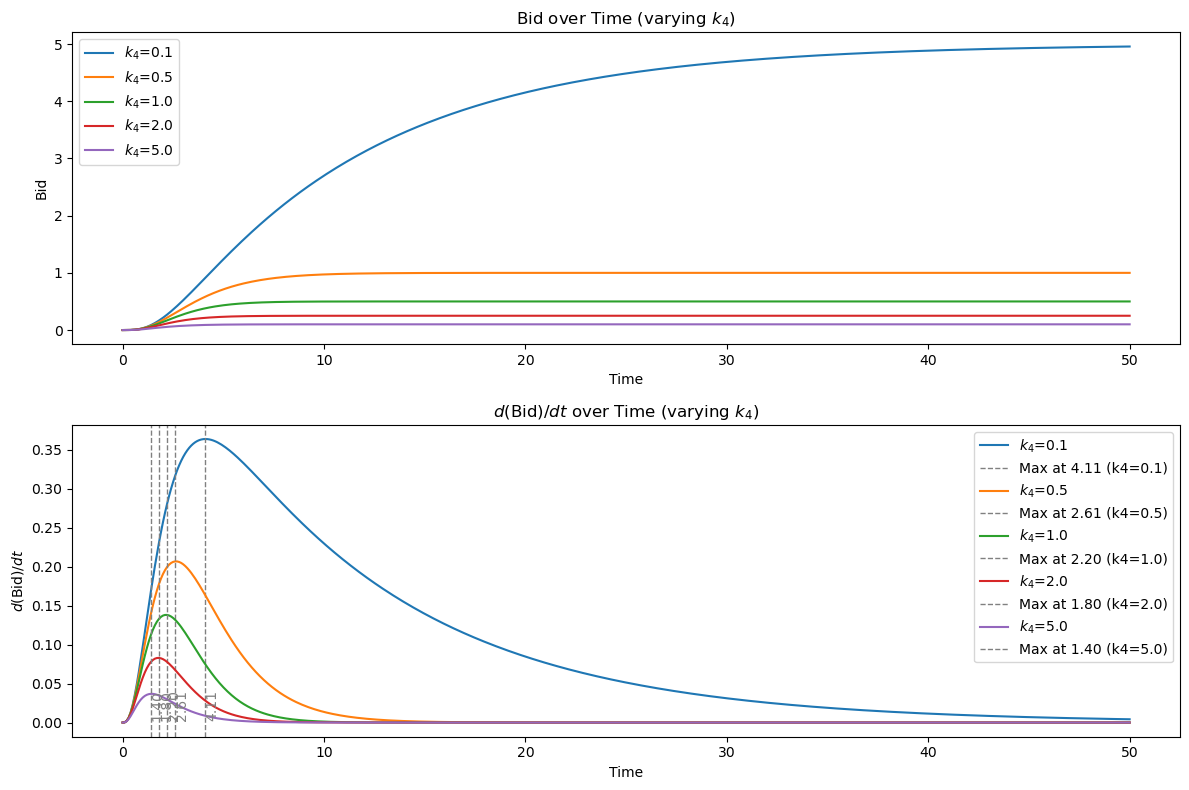

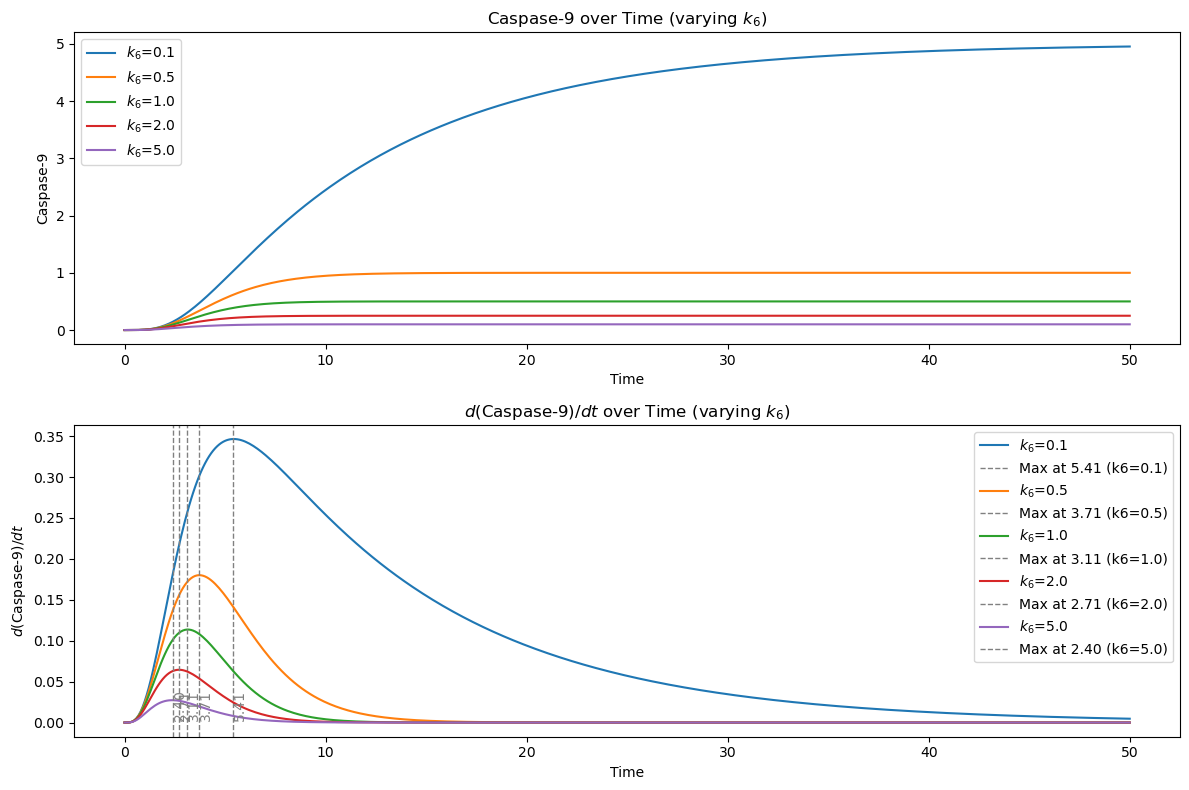

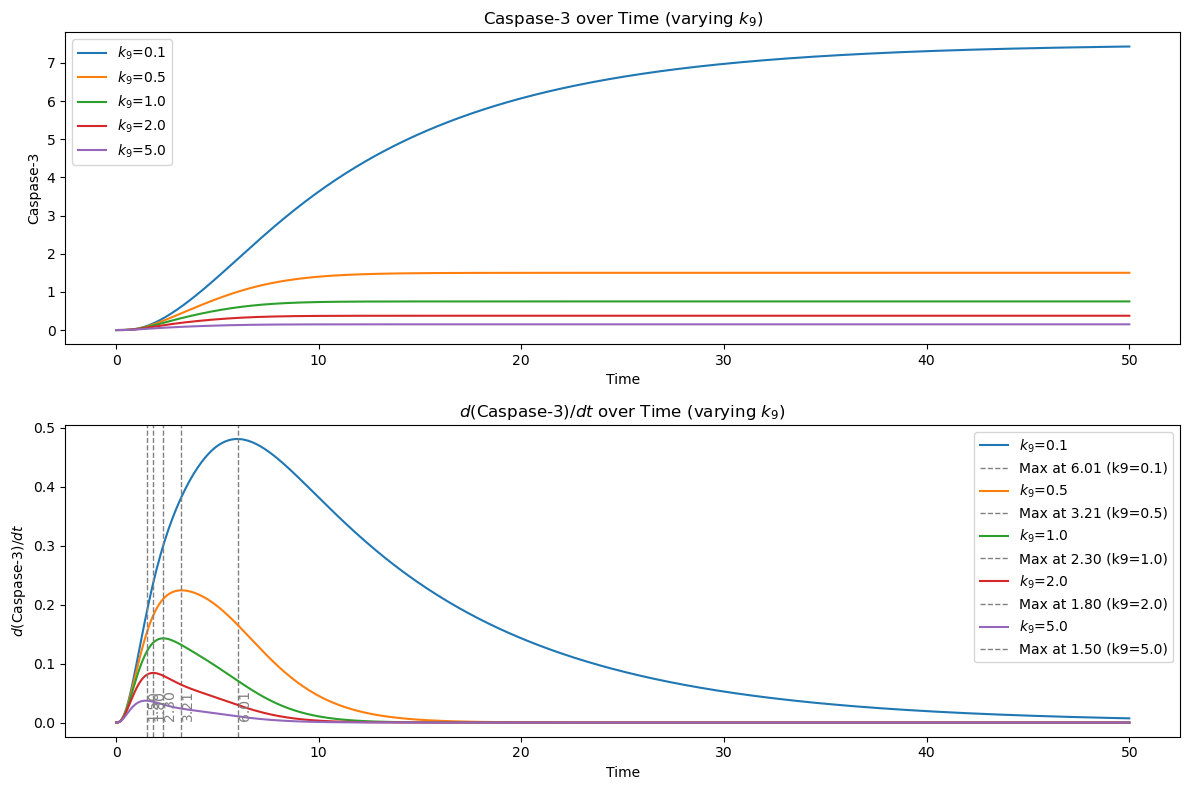

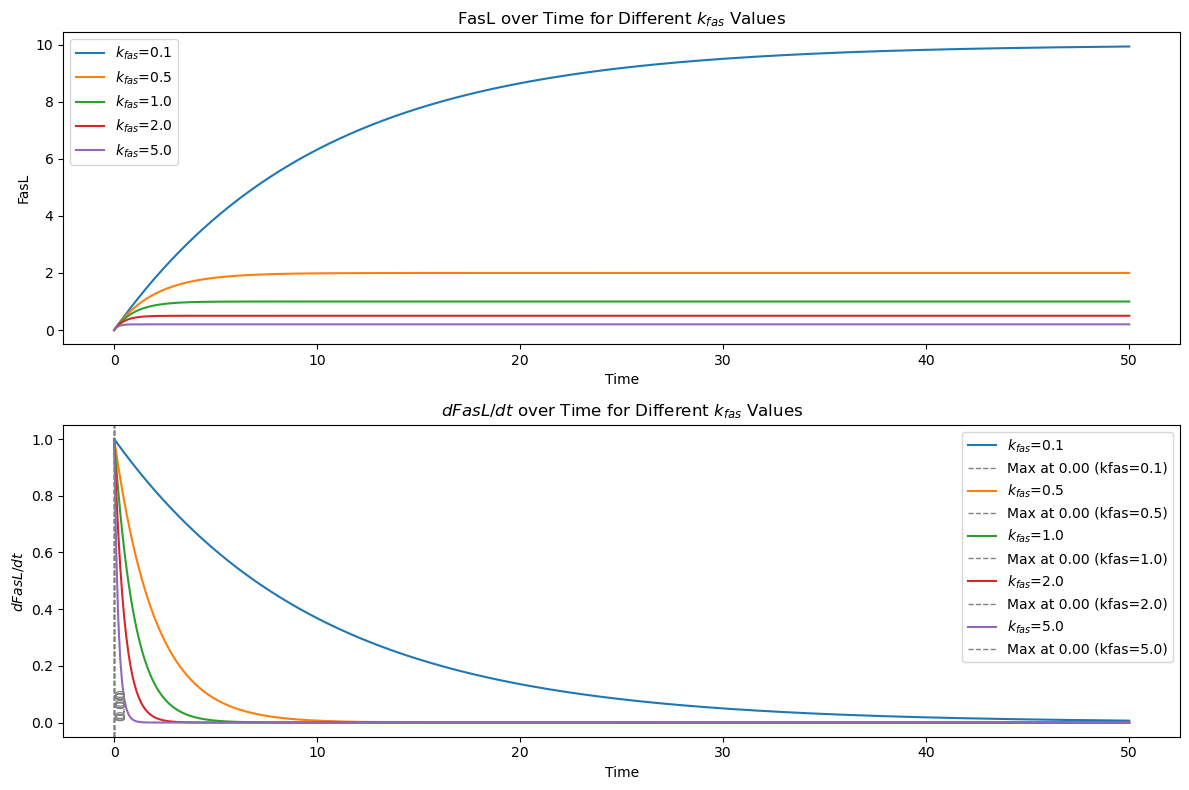

In [5]:
# Fixed parameters for activation constants; only degradation constant rates vary
k1 = 1.0
k3 = 1.0
k5 = 1.0
k7 = 1.0
k8 = 1.0
Kd = 1.0
n = 2
m = 2
S_fasl = 1.0
kfas = 1.0

default_k2 = 1.0  # Caspase-8 degradation
default_k4 = 1.0  # Bid degradation
default_k6 = 1.0  # Caspase-9 degradation
default_k9 = 1.0  # Caspase-3 degradation

# Initial levels for [Caspase-8, Bid, Caspase-9, Caspase-3, FasL]
y0 = [0, 0, 0, 0, 0]

t = np.linspace(0, 50, 500)

#############################
# Caspase-8 (varying k2) 
k2_values = [0.1, 0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(12, 8))

# Concentration plot for Caspase-8
plt.subplot(2,1,1)
for k2 in k2_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, k2, k3, default_k4, k5, default_k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    C8 = sol[:, 0]
    plt.plot(t, C8, label=f'$k_2$={k2}')
plt.title('Caspase-8 over Time (varying $k_2$)')
plt.xlabel('Time')
plt.ylabel('Caspase-8')
plt.legend()

# Derivative plot for Caspase-8 with dotted lines and annotation
plt.subplot(2,1,2)
for k2 in k2_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, k2, k3, default_k4, k5, default_k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    dC8_dt = [caspase_cascade_ode(state, 0, k1, k2, k3, default_k4, k5, default_k6, 
                                   k7, k8, default_k9, Kd, n, m, S_fasl, kfas)[0] for state in sol]
    plt.plot(t, dC8_dt, label=f'$k_2$={k2}')
    
    # Find time where dC8/dt is maximum
    max_index = np.argmax(dC8_dt)
    max_time = t[max_index]
    plt.axvline(max_time, color='gray', linestyle='--', linewidth=1,
                label=f'Max at {max_time:.2f} (k2={k2})')
    # Annotate the x-axis with the maximum time value.
    ylim = plt.ylim()
    plt.text(max_time, ylim[0] + 0.05*(ylim[1]-ylim[0]), f'{max_time:.2f}', rotation=90,
             color='gray', verticalalignment='bottom')
plt.title('$d($Caspase-8$)/dt$ over Time (varying $k_2$)')
plt.xlabel('Time')
plt.ylabel('$d($Caspase-8$)/dt$')
plt.legend()
plt.tight_layout()
plt.show()

#############################
# Bid (varying k4)
k4_values = [0.1, 0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(12, 8))

# Concentration plot for Bid
plt.subplot(2,1,1)
for k4 in k4_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, default_k2, k3, k4, k5, default_k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    Bid = sol[:, 1]
    plt.plot(t, Bid, label=f'$k_4$={k4}')
plt.title('Bid over Time (varying $k_4$)')
plt.xlabel('Time')
plt.ylabel('Bid')
plt.legend()

# Derivative plot for Bid with dotted lines and annotation
plt.subplot(2,1,2)
for k4 in k4_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, default_k2, k3, k4, k5, default_k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    dBid_dt = [caspase_cascade_ode(state, 0, k1, default_k2, k3, k4, k5, default_k6, 
                                    k7, k8, default_k9, Kd, n, m, S_fasl, kfas)[1] for state in sol]
    plt.plot(t, dBid_dt, label=f'$k_4$={k4}')
    
    max_index = np.argmax(dBid_dt)
    max_time = t[max_index]
    plt.axvline(max_time, color='gray', linestyle='--', linewidth=1,
                label=f'Max at {max_time:.2f} (k4={k4})')
    ylim = plt.ylim()
    plt.text(max_time, ylim[0] + 0.05*(ylim[1]-ylim[0]), f'{max_time:.2f}', rotation=90,
             color='gray', verticalalignment='bottom')
plt.title('$d($Bid$)/dt$ over Time (varying $k_4$)')
plt.xlabel('Time')
plt.ylabel('$d($Bid$)/dt$')
plt.legend()
plt.tight_layout()
plt.show()

#############################
# Caspase-9 (varying k6) 
k6_values = [0.1, 0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(12, 8))

# Concentration plot for Caspase-9
plt.subplot(2,1,1)
for k6 in k6_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, default_k2, k3, default_k4, k5, k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    C9 = sol[:, 2]
    plt.plot(t, C9, label=f'$k_6$={k6}')
plt.title('Caspase-9 over Time (varying $k_6$)')
plt.xlabel('Time')
plt.ylabel('Caspase-9')
plt.legend()

# Derivative plot for Caspase-9 with dotted lines and annotation
plt.subplot(2,1,2)
for k6 in k6_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, default_k2, k3, default_k4, k5, k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    dC9_dt = [caspase_cascade_ode(state, 0, k1, default_k2, k3, default_k4, k5, k6, 
                                   k7, k8, default_k9, Kd, n, m, S_fasl, kfas)[2] for state in sol]
    plt.plot(t, dC9_dt, label=f'$k_6$={k6}')
    
    max_index = np.argmax(dC9_dt)
    max_time = t[max_index]
    plt.axvline(max_time, color='gray', linestyle='--', linewidth=1,
                label=f'Max at {max_time:.2f} (k6={k6})')
    ylim = plt.ylim()
    plt.text(max_time, ylim[0] + 0.05*(ylim[1]-ylim[0]), f'{max_time:.2f}', rotation=90,
             color='gray', verticalalignment='bottom')
plt.title('$d($Caspase-9$)/dt$ over Time (varying $k_6$)')
plt.xlabel('Time')
plt.ylabel('$d($Caspase-9$)/dt$')
plt.legend()
plt.tight_layout()
plt.show()

#############################
# Caspase-3 (varying k9)
k9_values = [0.1, 0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(12, 8))

# Concentration plot for Caspase-3
plt.subplot(2,1,1)
for k9 in k9_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, default_k2, k3, default_k4, k5, default_k6, k7, k8, k9, Kd, n, m, S_fasl, kfas))
    C3 = sol[:, 3]
    plt.plot(t, C3, label=f'$k_9$={k9}')
plt.title('Caspase-3 over Time (varying $k_9$)')
plt.xlabel('Time')
plt.ylabel('Caspase-3')
plt.legend()

# Derivative plot for Caspase-3 with dotted lines and annotation
plt.subplot(2,1,2)
for k9 in k9_values:
    sol = odeint(caspase_cascade_ode, y0, t, 
                 args=(k1, default_k2, k3, default_k4, k5, default_k6, k7, k8, k9, Kd, n, m, S_fasl, kfas))
    dC3_dt = [caspase_cascade_ode(state, 0, k1, default_k2, k3, default_k4, k5, default_k6, 
                                   k7, k8, k9, Kd, n, m, S_fasl, kfas)[3] for state in sol]
    plt.plot(t, dC3_dt, label=f'$k_9$={k9}')
    
    max_index = np.argmax(dC3_dt)
    max_time = t[max_index]
    plt.axvline(max_time, color='gray', linestyle='--', linewidth=1,
                label=f'Max at {max_time:.2f} (k9={k9})')
    ylim = plt.ylim()
    plt.text(max_time, ylim[0] + 0.05*(ylim[1]-ylim[0]), f'{max_time:.2f}', rotation=90,
             color='gray', verticalalignment='bottom')
plt.title('$d($Caspase-3$)/dt$ over Time (varying $k_9$)')
plt.xlabel('Time')
plt.ylabel('$d($Caspase-3$)/dt$')
plt.legend()
plt.tight_layout()
plt.show()

#############################
# FasL (varying kfas)
kfas_values = [0.1, 0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(12, 8))

# Concentration plot for FasL
plt.subplot(2,1,1)
for kfas in kfas_values:
    sol = odeint(caspase_cascade_ode, y0, t,
                 args=(k1, default_k2, k3, default_k4, k5, default_k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    FasL = sol[:, 4]
    plt.plot(t, FasL, label=f'$k_{{fas}}$={kfas}')
plt.title('FasL over Time for Different $k_{fas}$ Values')
plt.xlabel('Time')
plt.ylabel('FasL')
plt.legend()

# Derivative plot for FasL with dotted lines and annotation
plt.subplot(2,1,2)
for kfas in kfas_values:
    sol = odeint(caspase_cascade_ode, y0, t,
                 args=(k1, default_k2, k3, default_k4, k5, default_k6, k7, k8, default_k9, Kd, n, m, S_fasl, kfas))
    FasL = sol[:, 4]
    dFasL_dt = S_fasl - kfas * FasL
    plt.plot(t, dFasL_dt, label=f'$k_{{fas}}$={kfas}')
    
    max_index = np.argmax(dFasL_dt)
    max_time = t[max_index]
    plt.axvline(max_time, color='gray', linestyle='--', linewidth=1,
                label=f'Max at {max_time:.2f} (kfas={kfas})')
    ylim = plt.ylim()
    plt.text(max_time, ylim[0] + 0.05*(ylim[1]-ylim[0]), f'{max_time:.2f}', rotation=90,
             color='gray', verticalalignment='bottom')
plt.title('$dFasL/dt$ over Time for Different $k_{fas}$ Values')
plt.xlabel('Time')
plt.ylabel('$dFasL/dt$')
plt.legend()

plt.tight_layout()
plt.show()
